In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

2025-04-12 00:58:40.508552: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-12 00:58:40.554147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744412320.581041  131346 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744412320.589071  131346 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744412320.622431  131346 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Devices available:", tf.config.list_physical_devices())

TensorFlow version: 2.19.0
Num GPUs Available:  1
Devices available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


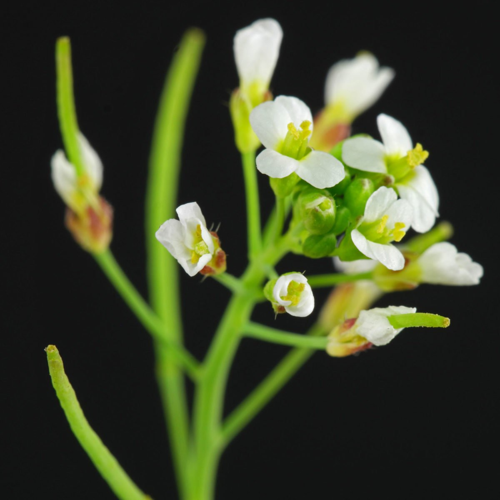

In [3]:
url = "https://pflanzenbestimmung.info/wp-content/uploads/2021/04/Arabidopsis-thaliana-4-1200x1200.jpg"

def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)

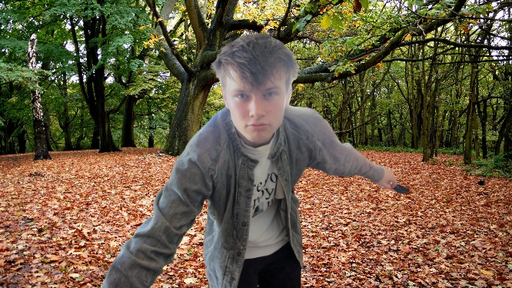

In [4]:
from PIL import Image

original_img = Image.open("pictures/forest_floor_background.jpg")

base_width = 512
w_percent = base_width / float(original_img.size[0])
h_size = int((float(original_img.size[1]) * float(w_percent)))

resized_img = original_img.resize((base_width, h_size), Image.Resampling.LANCZOS)

resized_img.show()

original_img = resized_img


In [5]:
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return tf.reduce_sum(losses)

def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

In [6]:
def run_deep_dream_with_octaves(img, model, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3, model_name=""):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  
  # Create tiled gradients for the specific model
  get_tiled_gradients = TiledGradients(model)
  
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print(f"Model: {model_name}, Octave {octave}, Step {step}")

  result = deprocess(img)
  return result

In [16]:
names = ['mixed9', 'mixed10']

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
standard_layers = [base_model.get_layer(name).output for name in names]
dream_model_standard = tf.keras.Model(inputs=base_model.input, outputs=standard_layers)

print("\nSetting up fine-tuned model...")
# model_path = "models/flower_finetuned_inceptionv3_enhanced.h5"
model_path ="models/insect_finetuned_inceptionv3.h5"
fine_tuned_model = load_model(model_path)
fine_tuned_layers = [fine_tuned_model.get_layer(name).output for name in names]
dream_model_finetuned = tf.keras.Model(inputs=fine_tuned_model.input, outputs=fine_tuned_layers)




Setting up fine-tuned model...


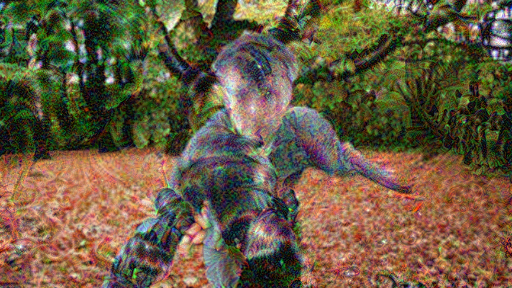

fine-tuned model result

Side-by-side comparison:


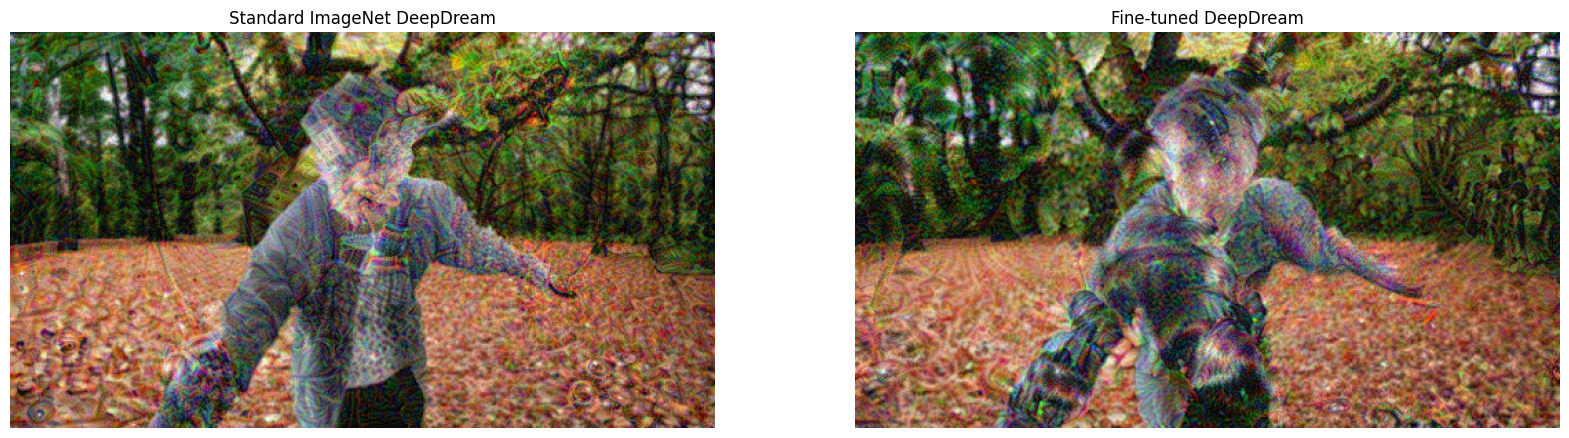

In [18]:
# Run DeepDream with standard ImageNet model
print("\nRunning DeepDream with standard ImageNet model...")
img_standard = run_deep_dream_with_octaves(
    img=original_img,
    model=dream_model_standard,
    steps_per_octave=100, 
    step_size=0.01,
    octave_scale=1.3,
    model_name="Standard ImageNet"
)

# Save the standard model result
display.clear_output(wait=True)
img_standard = tf.image.resize(img_standard, tf.shape(original_img)[:-1])
img_standard = tf.image.convert_image_dtype(img_standard/255.0, dtype=tf.uint8)
show(img_standard)
print("Standard ImageNet model result")
PIL.Image.fromarray(np.array(img_standard)).save('standard_model_dream.jpg')

# Run DeepDream with fine-tuned model
print("\nRunning DeepDream with fine-tuned model...")
img_finetuned = run_deep_dream_with_octaves(
    img=original_img,
    model=dream_model_finetuned,
    steps_per_octave=100, 
    step_size=0.01,
    octave_scale=1.3,
    model_name="Fine-tuned"
)

# Save the fine-tuned model result
display.clear_output(wait=True)
img_finetuned = tf.image.resize(img_finetuned, tf.shape(original_img)[:-1])
img_finetuned = tf.image.convert_image_dtype(img_finetuned/255.0, dtype=tf.uint8)
show(img_finetuned)
print("fine-tuned model result")
PIL.Image.fromarray(np.array(img_finetuned)).save('finetuned_model_dream.jpg')

# Display both side by side for comparison
print("\nSide-by-side comparison:")
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.array(img_standard))
plt.title("Standard ImageNet DeepDream")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.array(img_finetuned))
plt.title("Fine-tuned DeepDream")
plt.axis('off')
plt.show()

In [189]:
names = ['mixed9', 'mixed10']

print("Setting up standard InceptionV3 model...")
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
standard_layers = [base_model.get_layer(name).output for name in names]
dream_model_standard = tf.keras.Model(inputs=base_model.input, outputs=standard_layers)

print("\nSetting up fine-tuned model...")
model_path = "models/flower_finetuned_inceptionv3_enhanced.h5"
fine_tuned_model = load_model(model_path)
fine_tuned_layers = [fine_tuned_model.get_layer(name).output for name in names]
dream_model_finetuned = tf.keras.Model(inputs=fine_tuned_model.input, outputs=fine_tuned_layers)



Setting up standard InceptionV3 model...

Setting up fine-tuned model...


In [190]:
os.makedirs("dreams", exist_ok=True)

def compare_deepdreams(original_img, finetuned_model_name, img_name="output", names = ['mixed9', 'mixed10']):
    # Run DeepDream with standard ImageNet model
    print(f"\nRunning DeepDream on {img_name} with standard ImageNet model...")
    
    print("Setting up standard InceptionV3 model...")
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    standard_layers = [base_model.get_layer(name).output for name in names]
    dream_model_standard = tf.keras.Model(inputs=base_model.input, outputs=standard_layers)

    print("\nSetting up fine-tuned model...")
    model_path = finetuned_model_name
    fine_tuned_model = load_model(model_path)
    fine_tuned_layers = [fine_tuned_model.get_layer(name).output for name in names]
    dream_model_finetuned = tf.keras.Model(inputs=fine_tuned_model.input, outputs=fine_tuned_layers)


    img_standard = run_deep_dream_with_octaves(
        img=original_img,
        model=dream_model_standard,
        steps_per_octave=100,
        step_size=0.02,
        octave_scale=1.3,
        model_name="Standard ImageNet"
    )

    img_standard = tf.image.resize(img_standard, tf.shape(original_img)[:-1])
    img_standard = tf.image.convert_image_dtype(img_standard / 255.0, dtype=tf.uint8)
    standard_path = f'dreams/standard_{img_name}.jpg'
    Image.fromarray(np.array(img_standard)).save(standard_path)

    # Run DeepDream with fine-tuned model
    print(f"Running DeepDream on {img_name} with fine-tuned model...")
    img_finetuned = run_deep_dream_with_octaves(
        img=original_img,
        model=dream_model_finetuned,
        steps_per_octave=100,
        step_size=0.02,
        octave_scale=1.3,
        model_name="Fine-tuned"
    )

    img_finetuned = tf.image.resize(img_finetuned, tf.shape(original_img)[:-1])
    img_finetuned = tf.image.convert_image_dtype(img_finetuned / 255.0, dtype=tf.uint8)
    finetuned_path = f'dreams/finetuned_{img_name}_{str(names)}.jpg'
    Image.fromarray(np.array(img_finetuned)).save(finetuned_path)

    # Side-by-side plot
    print(f"\nSide-by-side comparison for {img_name}:")
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(img_standard))
    plt.title(f"{img_name} - Standard ImageNet DeepDream")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.array(img_finetuned))
    plt.title(f"{img_name} - Fine-tuned DeepDream")
    plt.axis('off')

    # Save the comparison plot
    comparison_path = f'dreams/comparison_{img_name}_{str(names)}.jpg'
    plt.savefig(comparison_path, bbox_inches='tight')
    plt.show()



In [191]:
names = ['mixed4','mixed5', 'mixed6','mixed7', 'mixed8','mixed9', 'mixed10']
for layer1, layer2 in zip(names, names[1:]):
    print(layer1, layer2)

mixed4 mixed5
mixed5 mixed6
mixed6 mixed7
mixed7 mixed8
mixed8 mixed9
mixed9 mixed10


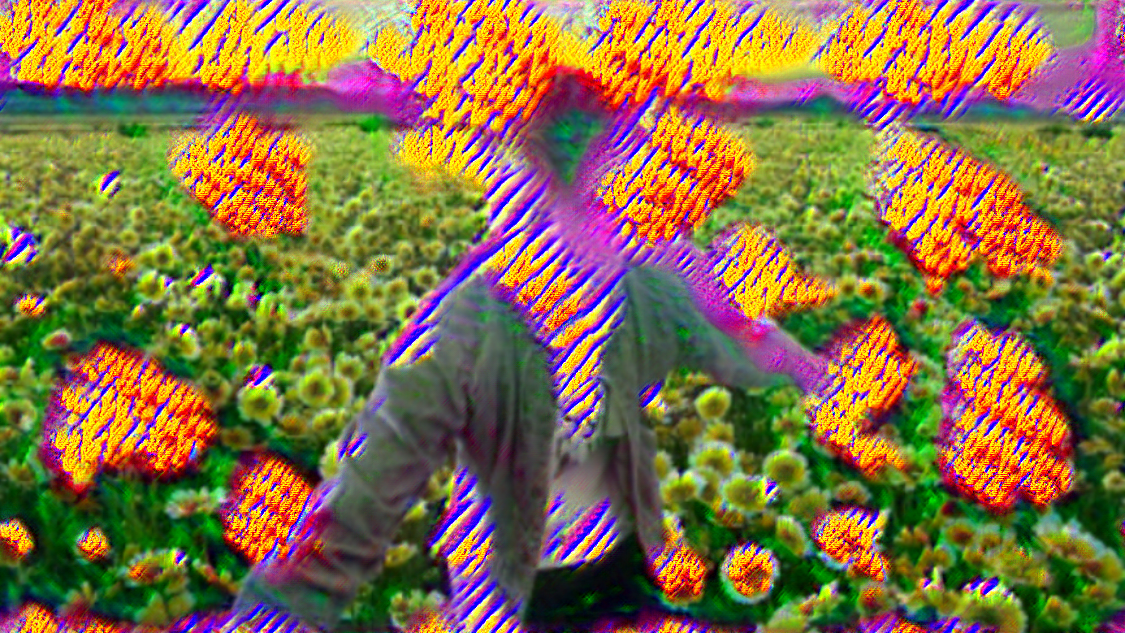

Model: Fine-tuned, Octave 2, Step 70


KeyboardInterrupt: 

In [11]:
image_folder = "pictures"
finetuned_model_name = "inceptionv3_flowers_final.h5"

for layer1, layer2 in zip(names, names[1:]):

    for filename in os.listdir(image_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(image_folder, filename)
            original_img = np.array(Image.open(filepath))
            original_img = tf.convert_to_tensor(original_img)

            compare_deepdreams(
                original_img, 
                finetuned_model_name,
                img_name=os.path.splitext(filename)[0],
                names = [layer1, layer2],
                
            )


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Folder where DeepDream outputs are saved
dreams_folder = "dreams"

# Loop through files and display only "comparison" images
for filename in sorted(os.listdir(dreams_folder)):
    if "comparison" in filename.lower() and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        filepath = os.path.join(dreams_folder, filename)
        print(f"\nShowing: {filename}")
        img = Image.open(filepath)

        plt.figure(figsize=(20, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(filename)
        plt.show()


# Enhance Features

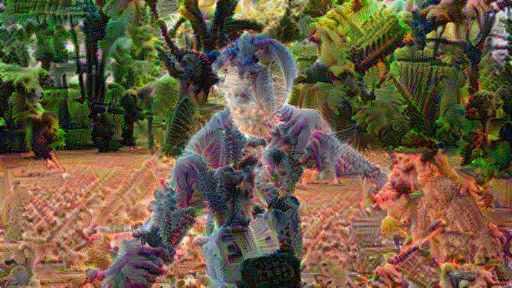

Targeted deep dream result


In [31]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Devices available:", tf.config.list_physical_devices())

# Function to download and preprocess an image
def download(url, max_dim=None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Function to load a local image
def load_image(path, max_dim=None):
    img = PIL.Image.open(path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

# Function to get model predictions for an image
def get_image_predictions(model, img, top_k=5):
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    preds = model.predict(img)
    decoded_preds = tf.keras.applications.inception_v3.decode_predictions(preds, top=top_k)[0]
    return decoded_preds

# Function to create a target vector based on a reference image
def create_target_vector(model, reference_img, class_idx=None):
    # If specific class index is provided, use it
    if class_idx is not None:
        target = np.zeros((1, 1000))
        target[0, class_idx] = 1.0
        return target
    
    # Otherwise use the top prediction from the reference image
    reference_img = tf.image.resize(reference_img, (299, 299))
    reference_img = tf.keras.applications.inception_v3.preprocess_input(reference_img)
    reference_img = tf.expand_dims(reference_img, axis=0)
    
    # Get predictions for the reference image
    predictions = model.predict(reference_img)
    
    # Return the raw predictions to be used as a target vector
    return predictions

# Modified loss function that enhances features that match the target
def calc_targeted_loss(img, feature_extractor, target_vector, layer_weights=None):
    img_batch = tf.expand_dims(img, axis=0)
    
    # Get intermediate layer activations
    layer_activations = feature_extractor(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    
    # If no layer weights are provided, use equal weights
    if layer_weights is None:
        layer_weights = [1.0] * len(layer_activations)
    
    # Calculate losses based on how much the activations match our target vector
    losses = []
    for i, act in enumerate(layer_activations):
        # For simplicity, we'll just maximize the mean activation
        # In a more sophisticated implementation, you could compute similarity
        # between these activations and the target feature vector
        loss = tf.math.reduce_mean(act) * layer_weights[i]
        losses.append(loss)
    
    return tf.reduce_sum(losses)

def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    img_rolled = tf.roll(img, shift=shift, axis=[0,1])
    return shift, img_rolled

class TargetedTiledGradients(tf.Module):
    def __init__(self, feature_extractor, target_vector, layer_weights=None):
        self.feature_extractor = feature_extractor
        self.target_vector = target_vector
        self.layer_weights = layer_weights

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[2], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.int32),)
    )
    def __call__(self, img, img_size, tile_size=512):
        shift, img_rolled = random_roll(img, tile_size)

        # Initialize the image gradients to zero.
        gradients = tf.zeros_like(img_rolled)

        # Skip the last tile, unless there's only one tile.
        xs = tf.range(0, img_size[1], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_size[0], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                # Calculate the gradients for this tile.
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)
                    # Extract a tile out of the image.
                    img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
                    loss = calc_targeted_loss(img_tile, self.feature_extractor, self.target_vector, self.layer_weights)

                # Update the image gradients for this tile.
                gradients = gradients + tape.gradient(loss, img_rolled)

        # Undo the random shift applied to the image and its gradients.
        gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

        # Normalize gradients
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients

def run_targeted_deep_dream(base_img, reference_img=None, class_idx=None, 
                          steps_per_octave=100, step_size=0.01, 
                          octaves=range(-2,3), octave_scale=1.3, layer_names=None, 
                          layer_weights=None):
    # Load base InceptionV3 model with classification layers
    inception_model = tf.keras.applications.InceptionV3(weights='imagenet')
    
    # Print top predictions for the reference image if provided
    if reference_img is not None:
        print("\nTop predictions for reference image:")
        predictions = get_image_predictions(inception_model, reference_img)
        for i, (imagenet_id, label, score) in enumerate(predictions):
            print(f"{i+1}: {label} ({score:.2f})")
    
    # Create target vector based on reference image or class index
    target_vector = create_target_vector(inception_model, reference_img, class_idx)
    
    # Set up feature extraction model
    if layer_names is None:
        layer_names = ['mixed9', 'mixed10']  # Default layers
    
    base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    layers = [base_model.get_layer(name).output for name in layer_names]
    feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=layers)
    
    # Prepare base image
    base_shape = tf.shape(base_img)
    img = tf.keras.utils.img_to_array(base_img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    
    # Create tiled gradients
    get_tiled_gradients = TargetedTiledGradients(feature_extractor, target_vector, layer_weights)
    
    # Run deep dream with octaves
    for octave in octaves:
        # Scale the image based on the octave
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        new_size = tf.cast(new_size, tf.int32)
        img = tf.image.resize(img, new_size)

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img, new_size)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print(f"Octave {octave}, Step {step}")

    result = deprocess(img)
    return result

# Example usage
if __name__ == "__main__":
    base_img_path = "pictures/forest_floor_background.jpg"  
    base_img = load_image(base_img_path, max_dim=512)
    show(base_img)
    print("Base image")
    
    # Load reference image to dream about
    reference_img_path = "dream_class_enhancer_images/Elk.jpg" 
    reference_img = load_image(reference_img_path, max_dim=512)
    show(reference_img)
    print("Reference image (target content)")
    
    # Run targeted deep dream
    result = run_targeted_deep_dream(
        base_img=base_img,
        reference_img=reference_img,
        steps_per_octave=100, 
        step_size=0.01,
        octave_scale=1.5,
        layer_names=['mixed5', 'mixed6', 'mixed7'], 
        layer_weights=[0.5, 1.0, 1.5]  
    )
    
    # Display and save result
    display.clear_output(wait=True)
    result = tf.image.resize(result, tf.shape(base_img)[:-1])
    result = tf.image.convert_image_dtype(result/255.0, dtype=tf.uint8)
    show(result)
    print("Targeted deep dream result")
    PIL.Image.fromarray(np.array(result)).save('targeted_dream_result.jpg')
    

In [ ]:
base_img_path = "pictures/forest_floor_background.jpg"  # Your base image
target_img_path = "dream_class_enhancer_images/elephant.jpg"  # Image with features you want to enhance